# Library

In [ ]:
pip install --upgrade transformers

In [1]:
import pandas as pd
import numpy as np
import requests
import json
from PIL import Image

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    MllamaForConditionalGeneration,
    AutoProcessor,
)

c:\ProgramData\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# LLaMA

<font style="font-size:20px"> bfloat16 </font>

<img src="https://cerebras.ai/wp-content/uploads/2023/01/bfloat-image-01-2048x863.png" width="600" height="300">

## 사용 방법

### Multimodal

LLaMA3.2는 11B와 90B에서 vision 입력 지원 <br>

#### Prompt Engineering

refer: [prompt engineering](https://www.llama.com/docs/how-to-guides/prompting/#prompting)

##### Base Prompt

> ```cmd
> <|begin_of_text|><|image|>If I had to write a haiku for this one
> ````

##### Instruct Model Prompt

> ```cmd
> <|begin_of_text|><|start_header_id|>user<|end_header_id|>
> 
> <|image|>Describe this image in two
> sentences<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> ````

#### Pre-trained

> ```python
> model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"
> model = MllamaForConditionalGeneration.from_pretrained(
>     model_id,
>     torch_dtype=torch.bfloat16,
>     device_map="auto",
> )
> processor = AutoProcessor.from_pretrained(model_id)
> 
> # url
> url = <url>
> image_path = requests.get(url, stream=True).raw
> 
> # file
> image_path = <path>
> image = Image.open(image_path)
> 
> prompt = "<|image|><|begin_of_text|>{prompt}"
> 
> # encoding
> inputs = processor(
>     image,
>     prompt.format(prompt=<instruction>),
>     return_tensors="pt"
> ).to(model.device)
> 
> outputs = model.generate(**inputs, max_new_tokens=30)
> ```

#### Instructed

> ```python
> model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"
> model = MllamaForConditionalGeneration.from_pretrained(
>     model_id,
>     torch_dtype=torch.bfloat16,
>     device_map="auto",
> )
> processor = AutoProcessor.from_pretrained(model_id)
> 
> # url
> url = <url>
> image_path = requests.get(url, stream=True).raw
> 
> # file
> image_path = <path>
> image = Image.open(image_path)
> 
> messages = [
>    {
>        "role": "user",
>        "content": [
>             {
>                 "type": "image"
>             },
>             {
>                 "type": "text",
>                 "text": "주어진 그림에 대하여 설명하려고 하면, 이것은: "
>             }
>         ]
>     }
> ]
> 
> # chat template
> input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
> 
> # encoding
> inputs = processor(
>     image,
>     input_text,
>     add_special_tokens=False,
>     return_tensors="pt"
> ).to(model.device)
> 
> outputs = model.generate(**inputs, max_new_tokens=30)
> ```

## Practice

### Inference

In [14]:
model_name = 'meta-llama/Llama-3.2-11B-Vision-Instruct'

model = MllamaForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map='auto',
  )
processor = AutoProcessor.from_pretrained(model_name)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.
Loading checkpoint shards: 100%|██████████| 5/5 [00:00<00:00,  8.07it/s]
Some parameters are on the meta device because they were offloaded to the cpu and disk.


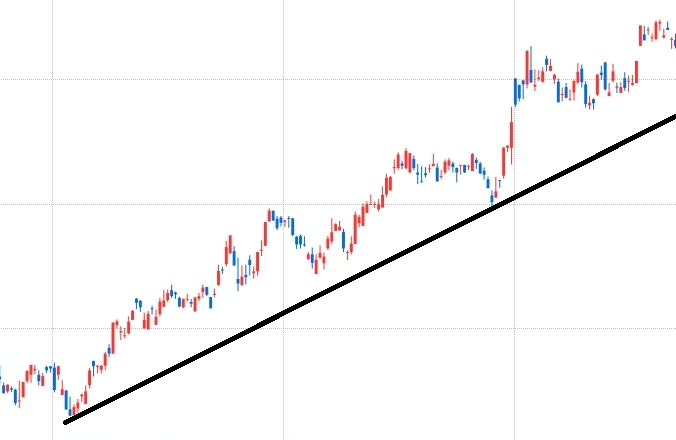

In [15]:
response = requests.get(
    'https://blog.kakaocdn.net/dn/blE6vx/btsFEKX8UeT/OK16c87DcBxhPUwB5J7DHk/img.png',
    stream=True,
)
image = Image.open(response.raw)
image

In [ ]:
prompt = '''
can you explain the given chart?

must include:
- whether current price is supported by the support line or not
- whether current price is resisted by the resistance line or not

exclude:
- just details about chart like background
'''
messages = [
    {
        'role': 'systems',
        'content': 'you are a chart analysis bot. your goal is to explain the given chart.'
    },
    {
        'role': 'user',
        'content': [
            {
                'type': 'image'
            },
            {
                'type': 'text',
                'text': prompt,
            }
        ]
    }
]

input_text = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
)

inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors='pt'
).to(model.device)

In [ ]:
output = model.generate(**inputs, max_new_tokens=300)
print(processor.decode(output[0]))

#### Fine-tuning

In [24]:
data = pd.read_csv('./data/captions.txt/captions.txt')
data = data.drop_duplicates(subset=['image'], keep='first')

data = data.iloc[:100]
data['image'] = data.image.apply(
    lambda x: Image.open(f'./data/Images/{x}')
)

data['Q'] = 'Explain the given image: '
data = data.rename(columns={'caption': 'A'})

In [7]:
model_name = 'meta-llama/Llama-3.2-11B-Vision-Instruct'

model = MllamaForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map='cpu',
  )
processor = AutoProcessor.from_pretrained(model_name)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.
Loading checkpoint shards: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]
Some parameters are on the meta device because they were offloaded to the cpu and disk.


In [12]:
processor.tokenizer.pad_token = '<|finetune_right_pad_id|>'
processor.tokenizer.pad_token_id = 128004

In [33]:
question_prompt = '''
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful assistant<|eot_id|><|start_header_id|>user<|end_header_id|>

<|image|>{user_prompt}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
'''

answer_prompt = '''
{question_prompt}
{answer}<|eot_id|>
'''

In [ ]:
data.Q = data.Q.apply(
    lambda x: question_prompt.format(user_prompt=x)
)

data.A = data.apply(
    lambda x: answer_prompt.format(
        question_prompt=x['Q'],
        answer=x['A'],
    ),
    axis=1
)

data.A = data.A.str.replace('^\n', '', regex=True)

In [41]:
data['Q_tokenized'] = data.apply(
    lambda x: processor(
                x['image'],
                x['Q'],
                max_length=256,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
                ),
                axis=1
)
data['A_tokenized'] = data.A.apply(
    lambda x: processor.tokenizer(
        x,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors='pt'),
    )

In [58]:
class QADataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        temp = self.data.iloc[idx]

        return {
            'input_ids': temp.Q_tokenized.get('input_ids')[0],
            'attention_mask': temp.Q_tokenized.get('attention_mask')[0],
            'pixel_values': temp.Q_tokenized.get('pixel_values')[0],
            'aspect_ratio_ids': temp.Q_tokenized.get('aspect_ratio_ids')[0],
            'aspect_ratio_mask': temp.Q_tokenized.get('aspect_ratio_mask')[0],
            'cross_attention_mask': temp.Q_tokenized.get('cross_attention_mask')[0],
            'labels': temp.A_tokenized.get('input_ids')[0],
        }

In [60]:
train, valid = train_test_split(
    data,
    test_size=0.2,
    random_state=0,
)
train_dataset = QADataset(train)
eval_dataset = QADataset(valid)

In [61]:
training_args = TrainingArguments(
    output_dir='./llama/',
    eval_strategy='epoch',
    learning_rate=1e-4,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

trainer.train()

You shouldn't move a model that is dispatched using accelerate hooks.


RuntimeError: You can't move a model that has some modules offloaded to cpu or disk.

In [67]:
response = requests.get(
    'https://vision.cs.uiuc.edu/pascal-sentences/',
    timeout=60,
)

ConnectTimeout: HTTPSConnectionPool(host='vision.cs.uiuc.edu', port=443): Max retries exceeded with url: /pascal-sentences/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000200140C0580>, 'Connection to vision.cs.uiuc.edu timed out. (connect timeout=60)'))

# Ollama

site: https://ollama.com/

LLM 모델을 로컬 환경에서 쉽게 사용할 수 있도록 해주는 플랫폼. <br>
사용자는 대규모 언어 모델을 자신의 컴퓨터에 설치하고 실행할 수 있으며, 프라이버시와 속도를 개선할 수 있음. <br>
Ollama는 개발자들이 AI를 활용한 애플리케이션을 쉽게 만들 수 있도록 다양한 기능과 도구를 제공. <br>
&nbsp;&nbsp;&nbsp;&nbsp; API를 통해 모델을 호출하거나, 사용자 정의 모델을 추가하는 등의 작업 가능. <br>

## 사용 방법

<font style="font-size:18px"> 다운로드 </font> <br>

사용하고자 하는 모델을 모델 리스트에서 확인 후 다운 <br>

> ```
> ollama pull llama3.2
> ollama pull llama3.2:1b
> ```

<br>

<font style="font-size:18px"> 실행 </font> <br>

사용하고자 하는 모델을 입력하여 실행 <br>

> ```
> ollama run llama3.2
> ollama run llama3.2:1b
> ```

### Customizing

1\. 모델 다운로드

> ```cmd
> ollama pull llama3.2
> ```

<br>

2\. 아래와 같이 Modelfile 생성

> ```cmd
> FROM llama3.2
> 
> # 온도 설정 (높을수록 창의적, 낮을수록 정확함)  
> PARAMETER temperature 1
> 
> # 시스템 메시지 설정
> SYSTEM """
> You are a kid. Answer like kid.
> """
> ```

<br>

3\. 아래의 커맨드를 입력하여 실행

> ```cmd
> ollama create kid -f ./Modelfile
> ollama run kid
> ```

### 학습 모델 사용

1\. fine-tuning이 완료된 데이터 확인 <br>
&nbsp;&nbsp;&nbsp;&nbsp;transformers에서 output_dir에 지정한 폴더 하위의 checkpoint

<br>

2\. safetensor가 존재하는 위치에 llama.cpp 다운 <br>
&nbsp;&nbsp;&nbsp;&nbsp;site: https://github.com/ggerganov/llama.cpp <br>
&nbsp;&nbsp;&nbsp;&nbsp;command: git clone https://github.com/ggerganov/llama.cpp.git <br>

<br>

3\. llama.cpp를 통해 gguf 변환
> ```cmd
> python llama.cpp/convert_hf_to_gguf.py <dir> --outfile <output_file_name> --outtype <file_type>
> ```
- dir: safetensor가 존재하는 위치
- file_type: f16, f32 등

<br>

4\. Modelfile 생성

생성한 .gguf 파일을 아래와 같이 입력

> ```cmd
> FROM <output_file_name>
> ```

<br>

5\. 모델 생성 및 실행

> ```cmd
> ollama create <name> -f <modelfile_name>
> ollama run <name>
> ```


### API

#### generate

> ```python
> url = 'http://localhost:11434/api/generate'
> data = {
>     'model': 'llama3',
>     'prompt': '하늘은 왜 파란가요?'
> }
> 
> response = requests.post(url, json=data)
> ```

#### chat

> ```python
> url = 'http://localhost:11434/api/chat'
> data = {
>     'model': 'llama3.2',
>     'messages': [
>         {'role': 'user', 'content': '하늘은 왜 파란가요?'}
>     ]
> }
> 
> response = requests.post(url, json=data)
> ```

In [68]:
data = {
    'model': 'llama3.2:1b',
    'messages': [
        {
            'role': 'system',
            'content': 'you are a useful assisant.'
        },
        {
            'role': 'user',
            'content': '한국에 대해서 설명해줄래?'
        }
    ]
}

response = requests.post(
    'http://localhost:11434/api/chat',
    json=data,
)

In [ ]:
response = [json.loads(item) for item in response.text.split('\n')[:-1]]


In [102]:
print(''.join([item.get('message').get('content') for item in response]))

한국!

한국은 한국어, 영어, 중국, 일본, 이탈리아, 프랑스, 독일 및 other languages를 사용하는 전통과modern 언어의 국가입니다. 한국어는 한글로 기원된 언어로, 16세기경에서 가장早期로 선정되었습니다. 한국어는 유럽과 아시아 между로 전파되었고, modern timesでは 세계에서 가장 spokenlanguage 중 하나인 country code Top-level domain (ccTLD)로 사용됩니다.

한국의 역사와 문화는 매우 phong phú입니다. 한국은 고대 기원전 14,000년대부터 1910년대까지 식민지로 통치되었으며, 이 시기에는 유대인 및 동양 인종의 도입이 있었다. 한국은 독립을 거두고 1948년에 공화국으로 estable되었다.

한국의 문화는 유럽과 아시아의 종교적, 사회적,芸術적 장점에 의해 influencesReceived by many countries around the world.

한국어의 발전은 20세기 đầu반부터 시작되어 1960년대 후반까지 성장했습니다. 한국어는 세계적으로 점점 더 사용되는 language becomeMore popular로, modern times에도 한국어를 사용하는 사람들은 수백만 명이 있습니다.

 Korea has a rich history and culture that is reflected in its traditional and modern aspects. The country's history spans over 14,000 years from ancient civilizations to colonial rule, with influences from the introduction of Judaism and other cultures during this period. Today, Korean culture exhibits many similarities with European and Asian cultures due to the significant exc